In [2]:
import matplotlib.pyplot as plt
import tqdm

import os
import shutil
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from torchvision import transforms
from torch.utils.data.dataloader import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import Compose
from torchvision.transforms import RandomCrop, RandomHorizontalFlip, Normalize
from torchvision import models

from tensorboardX import SummaryWriter
writer = SummaryWriter()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. 원단 데이터 Train, Test 파일로 분리

In [2]:
# 데이터셋 나누기
def dataset_split(src_dir, dst_dir, train_ratio=0.8, seed=42):
    random.seed(seed)

    # 클래스별 폴더 순회 (denim, silk, cotton ...)
    for i, folder in enumerate(os.listdir(src_dir)): # 원본 폴더 안에 있는 클래스별 하위 폴더 이름들을 가져옴
        folder_path = os.path.join(src_dir, folder) # src_dir(예: "fabric")과 folder(예: "denim")을 합쳐서 "fabric/denim" 같은 실제 경로를 만듦.
        print(src_dir) 
        print(folder)
        print(folder_path)
        if not os.path.isdir(folder_path):
            continue  # 폴더가 아닐 경우 건너뜀

        # 이미지 파일 목록 가져오기
        images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        random.shuffle(images)

        # 8:2로 나누기
        split_idx = int(len(images) * train_ratio) # 전체 이미지 개수 × 0.8 → 나눌 기준 인덱스
        train_imgs = images[:split_idx] # 앞부분 80% → 학습용
        test_imgs = images[split_idx:] # 뒷부분 20% → 테스트용

        # train/test 디렉토리 만들기
        for phase, img_list in [("train", train_imgs), ("test", test_imgs)]: # ("train", train_imgs) 와 ("test", test_imgs) 를 차례대로 돌면서 작업
            phase_class_dir = os.path.join(dst_dir, phase, folder) # phase_class_dir : 저장할 폴더 경로 만들기 예: "dataset/train/denim", "dataset/test/denim"
            os.makedirs(phase_class_dir, exist_ok=True) # os.makedirs(..., exist_ok=True) : 폴더가 없으면 새로 만들고, 이미 있으면 그냥 넘어감.

            # 이미지 복사
            for img_name in img_list:
                src_path = os.path.join(folder_path, img_name)
                dst_path = os.path.join(phase_class_dir, img_name)
                shutil.copy(src_path, dst_path)
        print(f"{i}번째 {folder} 폴더 완료 ===== ")

In [3]:
src_dir = "./dataset/fabric"  # 원본 데이터셋 폴더 (fabric 안에 denim, silk 등 하위 폴더가 있음)
dst_dir = "./dataset"         # 나눠서 저장할 폴더 경로 (dataset이라는 폴더에 train, test로 나눔)
dataset_split(src_dir, dst_dir, train_ratio=0.8)

./dataset/fabric
Acrylic
./dataset/fabric\Acrylic
0번째 Acrylic 폴더 완료 ===== 
./dataset/fabric
Artificial_fur
./dataset/fabric\Artificial_fur
1번째 Artificial_fur 폴더 완료 ===== 
./dataset/fabric
Artificial_leather
./dataset/fabric\Artificial_leather
2번째 Artificial_leather 폴더 완료 ===== 
./dataset/fabric
Blended
./dataset/fabric\Blended
3번째 Blended 폴더 완료 ===== 
./dataset/fabric
Chenille
./dataset/fabric\Chenille
4번째 Chenille 폴더 완료 ===== 
./dataset/fabric
Corduroy
./dataset/fabric\Corduroy
5번째 Corduroy 폴더 완료 ===== 
./dataset/fabric
Cotton
./dataset/fabric\Cotton
6번째 Cotton 폴더 완료 ===== 
./dataset/fabric
Crepe
./dataset/fabric\Crepe
7번째 Crepe 폴더 완료 ===== 
./dataset/fabric
Denim
./dataset/fabric\Denim
8번째 Denim 폴더 완료 ===== 
./dataset/fabric
Felt
./dataset/fabric\Felt
9번째 Felt 폴더 완료 ===== 
./dataset/fabric
Fleece
./dataset/fabric\Fleece
10번째 Fleece 폴더 완료 ===== 
./dataset/fabric
Leather
./dataset/fabric\Leather
11번째 Leather 폴더 완료 ===== 
./dataset/fabric
Linen
./dataset/fabric\Linen
12번째 Linen 폴더 완료 ==

In [ ]:
from common.transforms import get_transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image


# 전처리
train_transform = get_transforms("train")
test_transform = get_transforms("test")

train_raw = ImageFolder("./dataset/train", transform=train_transform)
test_raw = ImageFolder("./dataset/test", transform=test_transform)


# 병합된 클래스 매핑 -> 8개의 클래스로 병합
class_merge_map = {
    'Cotton': 0,
    'Linen': 0,
    'Viscose': 0,
    'Blended': 1,
    'Polyester': 1,
    'Nylon': 1,
    'Satin': 2,
    'Silk': 2,
    'Wool': 3,
    'Acrylic': 3,
    'Fleece': 4,
    'Terrycloth': 4,
    'Chenille': 4,
    'Denim': 5,
    'Corduroy': 5,
    'Velvet': 6,
    'Crepe': 6,
    'Leather': 7
}


# 클래스 병합
class FilteredImageFolder(Dataset):
    def __init__(self, imagefolder_dataset, class_merge_map):
        self.transform = imagefolder_dataset.transform
        self.loader = imagefolder_dataset.loader
        
        # 원래 클래스 인덱스 → 클래스 이름 리스트
        idx_to_class = imagefolder_dataset.classes  # ex) ['Acrylic', 'Blended', ...]
        
        # 병합된 샘플을 저장할 리스트 초기화
        self.samples = []

        for path, label in imagefolder_dataset.samples:
            class_name = idx_to_class[label]

            # class_merge_map에 해당 클래스가 있으면 병합된 라벨 가져오기
            if class_name in class_merge_map:
                merged_label = class_merge_map[class_name]
                 # 병합된 라벨로 샘플 저장 (이미지 경로, 병합된 라벨)
                self.samples.append((path, merged_label))
            # else: 없으면 그냥 제외

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = self.loader(path)
        if self.transform:
            image = self.transform(image)
        return image, label
        

# 병합 적용
train_dataset = FilteredImageFolder(train_raw, class_merge_map)
test_dataset = FilteredImageFolder(test_raw, class_merge_map)

# Dataloader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 2. 데이터 불러오기 및 전치리

In [ ]:
MEAN = (0.485, 0.456, 0.406) # 해당 데이터는 정규화시 사용되는 평균값으로, 실제 데이터의 평규값을 구해야합니다.
STD = (0.229, 0.224, 0.225)  # 해당 데이터는 정규화시 사용되는 표준편차값으로, 실제 데이터의 표준편차값 구해야합니다.

transforms_train = transforms.Compose([
    transforms.ToTensor(),              # tensor 로 데이터 타입을 바꿉니다
    # transforms.RandomCrop((224,224)),   # # 원본 이미지에서 224x224 크기를 랜덤한 위치에서 잘라냄
    transforms.Resize((224, 224)),      # 이미지 사이즈를 변경합니다. (이는 사용 모델에 따라 변경 될 수 있음)
    # transforms.Grayscale(num_output_channels=3),             # 이 이미지의 경우 흑백으로 처리하는 것이 좋습니다. 근데 RGB 채널이 있으므로 이 함수로 흑백으로 변환합니다.
    RandomHorizontalFlip(p=0.5),        # 과적합을 막기 위해 이미지를 랜덤으로 좌우 대칭을 변환합니다.
    transforms.RandomRotation(degrees=(-15, 15)),   # 과적합을 막기 위해 이미지를 무작위로 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # 과적합을 막기 위한 이미지의 밝기와 대비를 무작위로 변경
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # "이미지를 랜덤하게 자르고, 그 조각을 224x224로 변환하는 것!"
    transforms.Normalize(MEAN,STD)    # 흑백 이미지이므로 정규화는 생략
])

transforms_test = transforms.Compose([
    # transforms.CenterCrop((224,224)),   # 원본 이미지의 중앙 부분을 224x224 크기로 잘라냄
    transforms.ToTensor(),              # tensor 로 데이터 타입을 바꿉니다
    transforms.Resize((224, 224)),      # 이미지 사이즈를 변경합니다. (이는 사용 모델에 따라 변경 될 수 있음)
    # transforms.Grayscale(num_output_channels=3),             # 이 이미지의 경우 흑백으로 처리하는 것이 좋습니다. 근데 RGB 채널이 있으므로 이 함수로 흑백으로 변환합니다.
    # transforms.Normalize(MEAN,STD)    # 흑백 이미지이므로 정규화는 생략
])

# ImageFolder 함수를 사용하여 이미지를 불러옵니다.
# train 폴더 내부에는 내가 분류하고 싶은 이미지별로 폴더 정리가 되어있어야 합니다
# 이 프로젝트에서는 [, PNEUMONIA] 두개의 폴더로 분류가 되어있습니다.
# Normal 은 label 0번, PNEUMONIA 은 label 1번으로 라벨링됩니다.
# ImageFolder 함수는 이미지를 불러오는 동시에, 폴더 위치별로 정답 데이터가 라벨링 됩니다.
train_datasets = datasets.ImageFolder(root="dataset/train", transform=transforms_train)
test_datasets = datasets.ImageFolder(root="dataset/test", transform=transforms_test)

NameError: name 'transforms' is not defined

In [6]:
merge_map = {
    "Leather_group": ["Leather", "Artificial_leather"],
    "Fur_group": ["Artificial_fur", "Fleece"],
    "Cotton_group": ["Cotton", "Linen"],
    "Wool_group": ["Wool", "Felt"],
    "Silk_group": ["Silk", "Satin"],
    "Polyester_group": ["Polyester", "Nylon"],
    "Velvet_group": ["Velvet", "Suede"],
}
# 삭제할 클래스
remove_classes = ["Utilities", "Lut"]

## 데이터 확인해보기

### 학습 데이터 수 확인

In [ ]:
len(train_datasets)

In [8]:
len(test_datasets)

2149

### 분류할 클래스 리스트 보기

In [ ]:
train_datasets.classes

### 이미지 그리기

In [9]:
import numpy as np

# def denormalize(image, mean, std):
#     mean = torch.tensor(mean).view(3, 1, 1)
#     std = torch.tensor(std).view(3, 1, 1)
#     return image * std + mean

def view_img(tensor_image, title="title", cmap=None):
    """
    PyTorch 텐서(Tensor)를 시각화하는 함수
    """
    # 텐서를 넘파이 배열로 변환
    img_data = tensor_image.numpy()

    # 이미지 차원 순서 변경
    # PyTorch: (채널, 높이, 너비) -> Matplotlib: (높이, 너비, 채널)
    plt.imshow(np.transpose(img_data, (1, 2, 0)), cmap=cmap)

    # 이미지에 제목을 설정하고 화면에 표시
    plt.title(title)
    plt.show()

### + 튜플 데이터 타입에 대해서

In [10]:
image, label = train_datasets[0]
print(image) # 이미지
print(label) # 0
print(train_datasets.classes[label]) # Acrylic

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
0
Acrylic


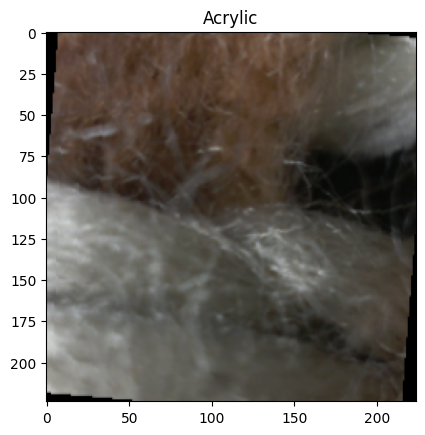

In [11]:
view_img(image, title=train_datasets.classes[label])

# 2. 데이터 배치사이즈로 분리하기

In [34]:
# DataLoader 를 사용하여 데이터를 나눈다
# batch_size 몇 개씩 그룹 지을지 정한다
# shuffle 데이터를 순서대로 나누는 것이 아니라 랜덤으로 섞어서 자른다 
# ⭐⭐ 학습에 영향을 줄 수 있으므로 Train Data 에는 True 로 설정 하자!
train_dataLoader = DataLoader(train_datasets, batch_size=32, shuffle=True) 
test_dataLoader = DataLoader(test_datasets, batch_size=32)

## 데이터 확인하기

tensor([[[0.6793, 0.6590, 0.6755,  ..., 0.6095, 0.6789, 0.6029],
         [0.6854, 0.6692, 0.6692,  ..., 0.6143, 0.5842, 0.5171],
         [0.6891, 0.6864, 0.6830,  ..., 0.6119, 0.5731, 0.5118],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.7038, 0.6877, 0.7134,  ..., 0.6338, 0.7093, 0.6282],
         [0.7137, 0.6997, 0.7058,  ..., 0.6436, 0.6094, 0.5330],
         [0.7164, 0.7154, 0.7181,  ..., 0.6467, 0.6022, 0.5309],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.7455, 0.7350, 0.7479,  ..., 0.6646, 0.7395, 0.6626],
         [0.7532, 0.7466, 0.7461,  ..., 0.6790, 0.6485, 0.5773],
         [0.7579, 0.7581, 0.7557,  ..., 0.6807, 0.6389, 0.

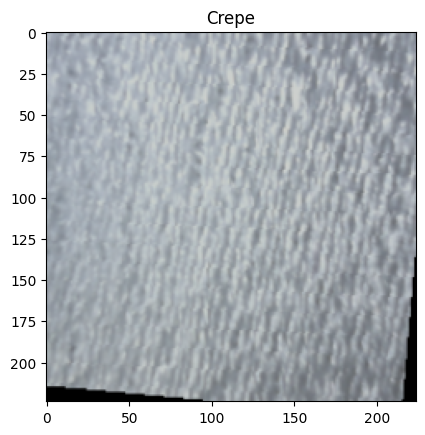

In [13]:
images, labels = next(iter(train_dataLoader)) # 튜플 (배치사이즈 만큼의 이미지들, 배치사이즈 만큼의 정답들)
print(images[0])
print(labels[0])

view_img(images[0], train_datasets.classes[labels[0]])

## 데이터 형태 확인하기

In [14]:
# 차원 수 확인하기
images.dim()

4

In [15]:
# 배치사이즈 수만큼 분리된 데이터의 형태 확인하기
# 각 차원의 의미: [배치사이즈, 채널수, 이미지 가로 사이즈, 이미지 세로 사이즈]
images.shape

torch.Size([32, 3, 224, 224])

In [16]:
# 이미지 한장의 데이터 형태 확인하기
images[0].shape

torch.Size([3, 224, 224])

## 이미지 그리드로 확인하기

In [17]:
def view_grid_img(images, title):
    images_data = torchvision.utils.make_grid([image for image in images])

    print(labels)
    view_img(images_data, title)

tensor([ 1,  9,  1, 14,  4,  9,  4,  4,  4,  1,  4, 14,  1,  1,  5,  4, 13,  9,
         4,  1,  4,  9,  9, 11,  1,  4,  4,  8,  4,  4,  4,  4])


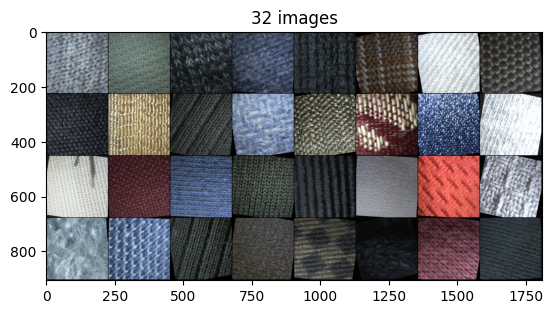

In [18]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_dataLoader)) # 튜플 (한개의 배치에 들어있는 이미지들, 한개의 배치에 들어있는 정답들)
images_data = torchvision.utils.make_grid(images) # 이미지를 그리드로 만든다

print(labels)
view_img(images_data, '32 images')

# 3. 모델 정의하기/준비하기

## 1) 모델 가져오기

In [19]:
# pretrained 는 deprecated 됨
# pretrained 라는 옵션, 파라미터가 더 이상 사용되지 않는다.
# 이는 곳 없어질수도 있는 위험한 파라미터값이다. > 이후에 이부분이 사라질 가능성 있음!
model = models.resnet50(pretrained = True)
model 

c:\POTENUP\IoLaundry\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\POTENUP\IoLaundry\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
# 모든 가중치 동결
for param in model.parameters():
    param.requires_grad=False  # 전체를 얼리고 분류기만 돌리는 과정, 미분을 하지 않겠다는 뜻

In [21]:
# 분류기만 돌아가게 해주는 방법
model.fc = nn.Linear(in_features=2048, out_features=15, bias=True)

### 분류기 수정 확인

In [22]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 4. 모델 학습하기

In [23]:
print(device)

cuda


In [ ]:
# 모델 학습 큰 흐름
# 1) 순전파
# 2) 손실함수
# 3) 역전파, 파라미터 업데이터

# 모델을 gpu에 넣는다
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

optim = Adam(model.parameters(), lr=1e-3) # 최적화 함수 0.001 ~ 0.003
criterion = nn.CrossEntropyLoss()         # 손실함수
epochs = 30

from tensorboardX import SummaryWriter
# 텐서보드 활용하여, 최적화 과정을 시각화 합니다
writer = SummaryWriter()
step = 0

for epoch in range(epochs):
    for images, labels in tqdm.tqdm(train_dataLoader): # (배치사이즈 만큼의 이미지 , 배치사이즈 만큼의 라벨)
        optim.zero_grad() # 📌 최적화 함수를 초기화 해야함 (한 번 학습시 마다)
        
        # 1) 순전파
        preds = model(images.to(device))
        
        # 2) 손실계산
        loss = criterion(preds, labels.to(device))

        writer.add_scalar('Loss/train',loss.item(), step)

        # 3) 역전파
        loss.backward()
        optim.step()

        step += 1 # step = step + 1

    print(f"{epoch + 1} loss : {loss}")

100%|██████████| 195/195 [01:30<00:00,  2.15it/s]


1 loss : 1.365024209022522


100%|██████████| 195/195 [01:42<00:00,  1.90it/s]


2 loss : 1.365042805671692


100%|██████████| 195/195 [01:46<00:00,  1.84it/s]


3 loss : 1.0439659357070923


100%|██████████| 195/195 [01:37<00:00,  2.00it/s]


4 loss : 1.0033601522445679


100%|██████████| 195/195 [01:28<00:00,  2.21it/s]


5 loss : 0.7642781138420105


100%|██████████| 195/195 [01:32<00:00,  2.11it/s]


6 loss : 0.8891634941101074


100%|██████████| 195/195 [01:25<00:00,  2.27it/s]


7 loss : 0.9845988750457764


100%|██████████| 195/195 [01:24<00:00,  2.31it/s]


8 loss : 1.3831138610839844


100%|██████████| 195/195 [01:22<00:00,  2.35it/s]


9 loss : 1.6246919631958008


100%|██████████| 195/195 [01:33<00:00,  2.08it/s]


10 loss : 0.7846983075141907


100%|██████████| 195/195 [01:32<00:00,  2.12it/s]


11 loss : 1.735431432723999


100%|██████████| 195/195 [01:27<00:00,  2.22it/s]


12 loss : 0.9754898548126221


100%|██████████| 195/195 [01:21<00:00,  2.38it/s]


13 loss : 0.9215850830078125


100%|██████████| 195/195 [01:25<00:00,  2.28it/s]


14 loss : 0.7488846778869629


100%|██████████| 195/195 [01:34<00:00,  2.06it/s]


15 loss : 0.3714551329612732


100%|██████████| 195/195 [01:29<00:00,  2.17it/s]


16 loss : 0.8966590762138367


100%|██████████| 195/195 [01:29<00:00,  2.17it/s]


17 loss : 0.8286479711532593


100%|██████████| 195/195 [01:21<00:00,  2.38it/s]


18 loss : 1.1613035202026367


100%|██████████| 195/195 [01:23<00:00,  2.33it/s]


19 loss : 0.7839969992637634


100%|██████████| 195/195 [01:22<00:00,  2.35it/s]


20 loss : 0.9691046476364136


100%|██████████| 195/195 [01:29<00:00,  2.17it/s]


21 loss : 0.9238407611846924


100%|██████████| 195/195 [01:35<00:00,  2.05it/s]


22 loss : 0.7834302186965942


100%|██████████| 195/195 [01:33<00:00,  2.09it/s]


23 loss : 0.7045263051986694


100%|██████████| 195/195 [01:32<00:00,  2.10it/s]


24 loss : 1.395755410194397


100%|██████████| 195/195 [01:35<00:00,  2.05it/s]


25 loss : 1.0540162324905396


100%|██████████| 195/195 [01:26<00:00,  2.25it/s]


26 loss : 0.8142123818397522


100%|██████████| 195/195 [01:27<00:00,  2.24it/s]


27 loss : 0.6809759736061096


100%|██████████| 195/195 [01:19<00:00,  2.46it/s]


28 loss : 0.703589677810669


100%|██████████| 195/195 [01:27<00:00,  2.23it/s]


29 loss : 0.8706283569335938


100%|██████████| 195/195 [01:28<00:00,  2.19it/s]

30 loss : 0.6874882578849792


💡 가중치 초기화(Weight Initialization)를 해야하는 이유
모델의 층이 깊어질수록,   
활성화 함수 이후 데이터의 분포가 한쪽으로 쏠릴 수 있다.   
이러한 현상은 효율적이고 원활한 모델 학습을 방해한다.

# 5. 모델 저장하기

### 가중치만 저장 (state_dict)

In [25]:
file_name1 = 'model/08_resnet50_클래스_merge_model.pth'
if os.path.exists(file_name1):
    print("이미 존재하는 파일임, 파일 이름을 바꾸세요")
else:
    torch.save(model.state_dict(), file_name1)

# 저장한 데이터 불러올 때 코드
# model.load_state_dict(torch.load("model_weights.pth"))

### 모델 전체 저장

In [26]:
file_name2 = 'full_model/08_resnet50_클래스_merge_model.pth'
if os.path.exists(file_name2):
    print("이미 존재하는 파일임, 파일 이름을 바꾸세요")
else:
    torch.save(model, file_name2)

# 저장한 데이터 불러올 때 코드
# model = torch.load("model_full.pth")

## 저장한 모델 불러오기

In [35]:
load_model = models.resnet50(pretrained=True)
load_model.fc = nn.Linear(in_features=2048, out_features=24, bias=True)
load_model.load_state_dict(torch.load('model/01_resnet50_model.pth', map_location=device))
load_model

c:\POTENUP\IoLaundry\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\POTENUP\IoLaundry\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 6. 모델 평가

f1 스코어로 평가한다

## 테스트하기

In [36]:
print(test_dataLoader)

In [ ]:
from torchmetrics.classification import MulticlassF1Score, MulticlassConfusionMatrix

num_classes = 24  # 클래스 개수
f1_metric = MulticlassF1Score(num_classes=num_classes).to(device)
cm_metric = MulticlassConfusionMatrix(num_classes=num_classes).to(device)

load_model.eval()
load_model.to(device)

with torch.no_grad():
    for images, labels in test_dataLoader:
        preds = load_model(images.to(device))  # [[각 클래스 확률]]
        _, preds = torch.max(preds.data, dim=1)  # 가장 높은 확률 → 예측 클래스

        # F1 계산용 업데이트
        f1_metric.update(preds, labels.to(device))
        # 혼동행렬 업데이트
        cm_metric.update(preds, labels.to(device))

# F1 스코어 계산
f1_score = f1_metric.compute()
print("F1 Score:", f1_score.item())

# 혼동행렬 계산
conf_matrix = cm_metric.compute().cpu().numpy()
# print("Confusion Matrix:\n", conf_matrix)

# 각 클래스별 틀린 개수
wrong_counts = conf_matrix.sum(axis=1) - conf_matrix.diagonal()
for i, wrong in enumerate(wrong_counts):
    print(f"Class {i}: 틀린 개수 = {wrong}")

# 클래스별 잘못 예측한 경우 출력
for actual in range(num_classes):
    for predicted in range(num_classes):
        if actual != predicted and conf_matrix[actual, predicted] > 0:
            print(f"실제 클래스 {actual} → 예측 클래스 {predicted} : {conf_matrix[actual, predicted]} 번")


F1 Score: 0.0031955111771821976
Class 0: 틀린 개수 = 10
Class 1: 틀린 개수 = 329
Class 2: 틀린 개수 = 11
Class 3: 틀린 개수 = 17
Class 4: 틀린 개수 = 872
Class 5: 틀린 개수 = 17
Class 6: 틀린 개수 = 127
Class 7: 틀린 개수 = 46
Class 8: 틀린 개수 = 25
Class 9: 틀린 개수 = 385
Class 10: 틀린 개수 = 88
Class 11: 틀린 개수 = 24
Class 12: 틀린 개수 = 22
Class 13: 틀린 개수 = 30
Class 14: 틀린 개수 = 136
Class 15: 틀린 개수 = 0
Class 16: 틀린 개수 = 0
Class 17: 틀린 개수 = 0
Class 18: 틀린 개수 = 0
Class 19: 틀린 개수 = 0
Class 20: 틀린 개수 = 0
Class 21: 틀린 개수 = 0
Class 22: 틀린 개수 = 0
Class 23: 틀린 개수 = 0
실제 클래스 0 → 예측 클래스 3 : 2 번
실제 클래스 0 → 예측 클래스 5 : 4 번
실제 클래스 0 → 예측 클래스 6 : 1 번
실제 클래스 0 → 예측 클래스 15 : 1 번
실제 클래스 0 → 예측 클래스 17 : 1 번
실제 클래스 0 → 예측 클래스 22 : 1 번
실제 클래스 1 → 예측 클래스 3 : 46 번
실제 클래스 1 → 예측 클래스 5 : 55 번
실제 클래스 1 → 예측 클래스 6 : 25 번
실제 클래스 1 → 예측 클래스 10 : 1 번
실제 클래스 1 → 예측 클래스 14 : 2 번
실제 클래스 1 → 예측 클래스 15 : 77 번
실제 클래스 1 → 예측 클래스 17 : 9 번
실제 클래스 1 → 예측 클래스 22 : 114 번
실제 클래스 2 → 예측 클래스 3 : 4 번
실제 클래스 2 → 예측 클래스 5 : 4 번
실제 클래스 2 → 예측 클래스 6 : 1 번
실제 클래스 2 → 예측 클래스 15 :